TODO 

- proofread

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

import os
os.chdir('/big/st/strasserl/spapros/docs')

from IPython.display import HTML, display, Image, HTML

from IPython.core.display import HTML

# Spapros Tutorial: Advanced Selection

This tutorial shows how to select a gene probeset with spapros.  
Next to the basic procedure, we explain several advanced use cases.
Additionally, the parameters are discussed. 

The used dataset contains 3k PBMCs from a healthy donor and is publicly available from
[10x Genomics](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)
[here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz).

You can also derive it from scanpy [here](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc3k.html#scanpy.datasets.pbmc3k), like we will do in this tutorial.

The preprocessed Anndata consists of log-normalized single cell RNAseq counts of 2638 cells 1838 genes.

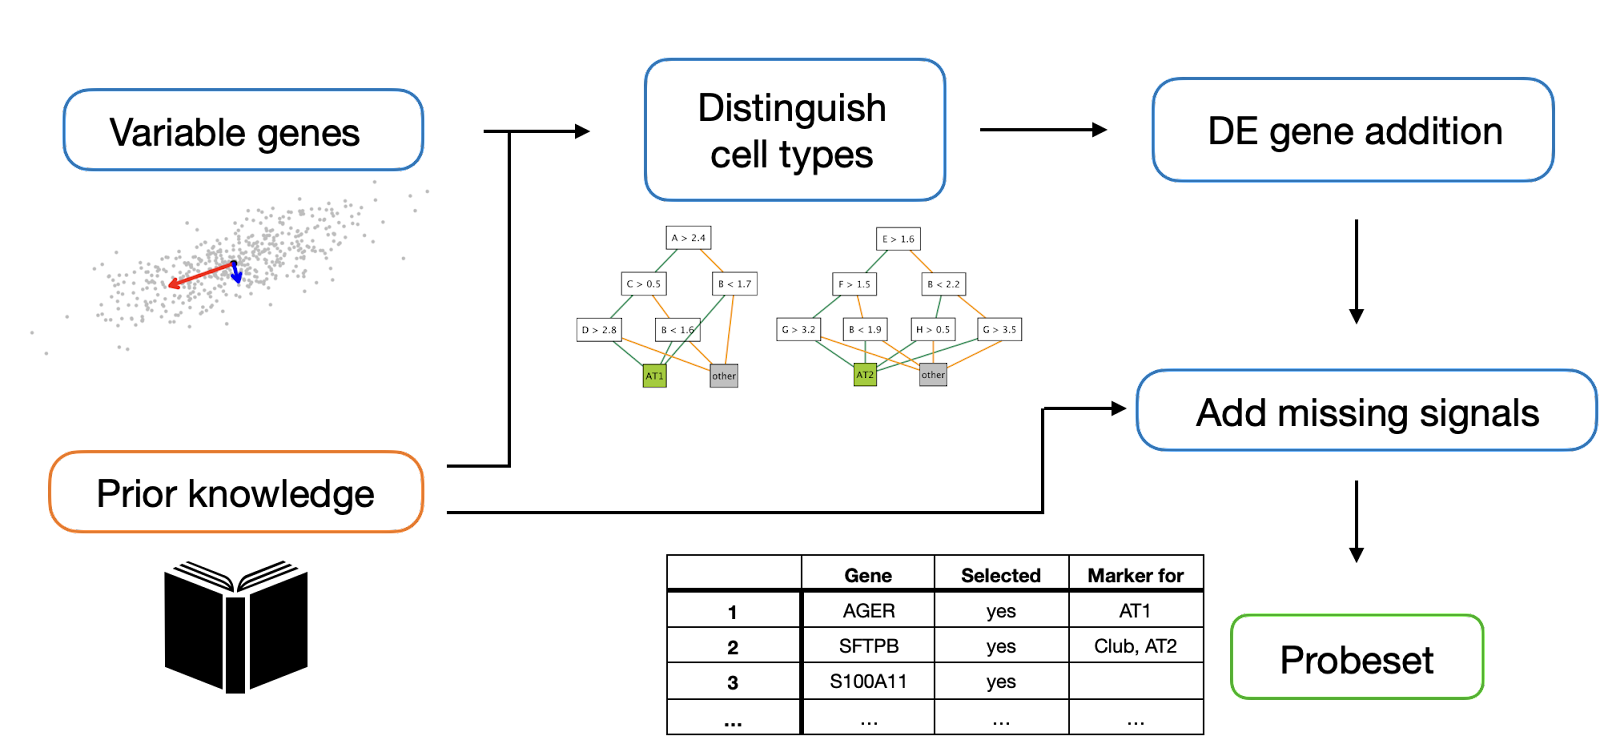

In [31]:
Image("../tutorials/abstract_figures/fig_03.png", width=700, embed=True)

The spapros probeset selection pipeline is optimized to simultanously optimize for transcriptional variation and cell type identification while taking prior knowledge, technical constraints and probe design. The main steps, as visualized in the figure above, are: 

**Variable genes**

The first step is the PCA based selection of genes that capture general variation.  

**Distinguish celltypes**

For each cell type, a binary classification tree is trained on the previously selected gene set. 

**DE gene addition**

Similarly, trees are trained on DE genes and compared to the trees trained on the PCA based selection. If a DE tree performs better with respect to cell type classification, the DE genes are added to the already selected gene set.

**Prior knowledge**

There are two possibilities to incorporate prior knowledge. For both, we present a use case in this tutorial: 
- [Select few additional genes](#ii.-Select-few-additional-genes): a set of pre-selected genes is augmented by combinatorially selecting around them
- [Selection with curated marker list](#iv.-Selection-with-curated-marker-list): add markers from a given list for cell types with too few markers


TODO: rough description of the spapros selection pipeline
#######################################################

takes into account prior knowledge, technical constraints, and probe design, while optimizing simultaneously for cell type identification and transcriptional variation
cell type identification and variation recovery while taking into account technical constraints and prior knowledge


The first step, a PCA based selection, extracts genes that capture general variation. The pipeline is biased towards using those genes and only adds other genes if performance criteria are not met. For each cell type a binary classification tree is trained on the PCA selected genes. The genes used in such trees provide a combinatorial rule to identify the given cell type. The classification performance for each cell type is compared to the performance of trees trained on DE genes. If the performance of a DE tree is higher than of the PCA tree we add DE genes to the selection pool and retrain the PCA tree. This ensures that we achieve optimal cell type classification performance. When setting up the DE trees we use an iterative procedure that includes more specific DE tests besides the 1-vs-all tests. This procedure places a strengthened focus on genes that can distinguish cell types which are hard to separate. Finally genes are ranked based on their feature importance in classification trees. Then all possible probe sequences are designed for the selected genes, and for each gene a set of non-overlapping probes with best properties (melting temperature and GC content) are selected. To account for technical constraints of expression levels a smoothed multiplicative penalty kernel is applied to the scores of PCA and DE based selections. Prior knowledge can be incorporated in two ways: 1. as a pre-selection of genes, so other genes are combinatorially selected around them, and 2. as a marker list from which genes are added for cell types where too few markers were selected.


**Content**  

0. [Import packages and setup](#0.-Import-packages-and-setup)  
1. [Load dataset](#1.-Load-dataset)  
2. [Prepare penalties](#2.-Prepare-penalties)  
3. [Use cases](#3.-Use-cases)  
    i. [Standard selection](#i.-Standard-selection)  
    ii. [Select few additional genes](#ii.-Select-few-additional-genes)  
    iii. [Cell type classification only](#iii.-Cell-type-classification-only)  
    iv. [Selection with curated marker list](#iv.-Selection-with-curated-marker-list)  
4. [Reference probeset selection](#4.-Reference-probeset-selection)     
5. [What's next](5.-#What's-next)  

<a id="Import-packages-and-setup"></a>

## 0. Import packages and setup

To run the notebook locally, create a conda environment using this [yaml file](../requirements_dev.yaml):

    conda create -f environment.yaml

Then add the conda environment as ipython kernel:

    python -m ipykernel install --user --name spapros --display-name Python (spapros)

In [3]:
from spapros import se, ev, pl
import spapros
from spapros.util import util
import scanpy as sc

from IPython.display import clear_output
import pandas as pd
import numpy as np
import os
import yaml

In [4]:
sc.settings.verbosity = 0
sc.logging.print_header()
print(f"spapros=={spapros.__version__}")

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.5 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6
spapros==0.1.0


## 1. Load dataset

In [5]:
adata = sc.datasets.pbmc3k()
adata_tmp = sc.datasets.pbmc3k_processed()
adata = adata[adata_tmp.obs_names,adata_tmp.var_names]
adata_raw = adata.copy()
sc.pp.normalize_total(adata, target_sum=1e4, key_added="size_factors")
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=1000)
adata.X = adata_raw.X
sc.pp.log1p(adata)
adata.obs['celltype'] = adata_tmp.obs['louvain']
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'size_factors', 'celltype'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

## 2. Prepare penalties

The ProbesetEvaluator can apply several penalties. Here is an overview of the available parameters: 

**PCA**

pca_penalties:  
        List of keys for columns in `adata.var` containing penalty factors that are multiplied with the
        scores for PCA based gene selection.
        
corr_penalty:  
        Function that maps values from [0,1] to [0,1]. It describes an iterative penalty function
        that is applied on pca selected genes. The highest correlation with already selected genes
        to the next selected genes are penalized according the given function. (max correlation is
        recomputed after each selected gene).
        
        
        
**DE**  

DE_penalties:  
        List of keys for columns in `adata.var` containing penalty factors that are multiplied with the 
        scores for DE based gene selection.
        
        
**marker**
          
m_penalties_adata_celltypes:  
        List of keys for columns in `adata.var` containing penalty factors to filter out marker genes if a 
        gene's penalty < threshold for celltypes in adata.
          
m_penalties_list_celltypes:  
        List of keys for columns in `adata.var` containing penalty factors to filter out marker genes if a 
        gene's penalty < threshold for celltypes not in adata.

To account for technical constraints of expression levels, penalty scores can be multiplied to the scores of PCA and DE based selections. We show here how you can design penalty scores with a smoothed plateau penalty kernel and store them in an `adata.var` column to use the `pca_penalties` and the `DE_penalties` parameter of the `ProbesetSelector`. 


In [6]:
# from experimental experience we select an upper and a lower expression threshold.
lower_th = 2
upper_th = 6

# get the expression quantiles
util.get_expression_quantile(adata, q=0.99, log1p=False, zeros_to_nan=False, normalise=False)

# we don't set fixed expression thresholds. Instead we introduce smoothness factors (heuristic user choice)
factor = 1
var = [factor*0.1,factor*0.5]

# design the penalty kernel 
penalty = util.plateau_penalty_kernel(var=var, x_min=lower_th, x_max=upper_th)

# calcluate the expression penalties
adata.var['expression_penalty'] = penalty(adata.var[f'quantile_0.99'])

# upper 
penalty = util.plateau_penalty_kernel(var=var, x_min=None, x_max=upper_th)
adata.var['expression_penalty_upper'] = penalty(adata.var[f'quantile_0.99'])

# lower
util.get_expression_quantile(adata,q=0.99, log1p=False, zeros_to_nan=True, normalise=False)
penalty = util.plateau_penalty_kernel(var=var,x_min=lower_th,x_max=None)
adata.var['expression_penalty_lower'] = penalty(adata.var[f'quantile_0.99'])

## 3. Use cases

We will go through some uses cases for gene selection, starting with the basic procedure.

### i. Standard selection

#### a. Set up the ProbesetSelector


In [7]:
# create an instance of the ProbesetSelector class
selector = se.ProbesetSelector(adata, 
                               n=50, 
                               celltype_key="celltype", 
                               verbosity=1, 
                               save_dir=None, 
                               # columns where penalty scores (created above) are stored:
                               pca_penalties=["expression_penalty", "expression_penalty_upper", "expression_penalty_lower"],
                               DE_penalties=["expression_penalty", "expression_penalty_upper", "expression_penalty_lower"])

The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3


TODO  
**parameter discussion**

marker_corr_th:  
     Minimal correlation to consider a gene as captured.


n_list_markers:     
    Minimal number of markers per celltype that are at least selected. Selected means 
    either selecting genes from the marker list or having correlated genes in the 
    already selected panel. (Set the correlation threshold with 
    marker_selection_hparams['penalty_threshold']). If you want to select a different 
    number of markers for celltypes in adata and celltypes only in the marker
    list, set e.g.: n_list_markers = {'adata_celltypes':2,'list_celltypes':3}

min_mean_difference:  
    Minimal difference of mean expression between at least one celltype and the 
    background. In this test only cell types from `celltypes` are taken into account 
    (also for the background). This minimal difference is applied as an additional 
    binary penalty in pca_penalties, DE_penalties and m_penalties_adata_celltypes.


#### b. Start the selection

In [8]:
selector.select_probeset()

Output()

The selected probeset can be examined like this: 

In [9]:
selector.probeset

,gene_nr,selection,rank,marker_rank,tree_rank,importance_score,pca_score,pre_selected,prior_selected,pca_selected,celltypes_DE_1vsall,celltypes_DE_specific,celltypes_DE,celltypes_marker,list_only_ct_marker,required_marker,required_list_marker
LST1,1,True,1.0,1.0,1.0,0.747301,1.574997e+00,False,False,True,FCGR3A+ Monocytes,,FCGR3A+ Monocytes,FCGR3A+ Monocytes,False,True,False
HLA-DPB1,2,True,1.0,1.0,1.0,0.630537,1.707121e+00,False,False,True,Dendritic cells,,Dendritic cells,Dendritic cells,False,True,False
HLA-DQA1,3,True,1.0,1.0,1.0,0.602538,1.034986e+00,False,False,True,B cells,,B cells,B cells,False,True,False
IL32,4,True,1.0,1.0,1.0,0.600759,3.084704e+00,False,False,True,CD4 T cells,,CD4 T cells,CD4 T cells,False,True,False
GZMB,5,True,1.0,1.0,1.0,0.525277,1.317827e+00,False,False,True,NK cells,,NK cells,NK cells,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF594,996,False,NaN,NaN,NaN,NaN,4.928911e-15,False,False,False,,,,,False,False,False
ZNF587B,997,False,NaN,NaN,NaN,NaN,4.820120e-15,False,False,False,,,,,False,False,False
SYP,998,False,NaN,NaN,NaN,NaN,4.656269e-15,False,False,False,,,,,False,False,False
RP11-252A24.3,999,False,NaN,NaN,NaN,NaN,4.262044e-15,False,False,False,,,,,False,False,False


#### c. Vizualize the results

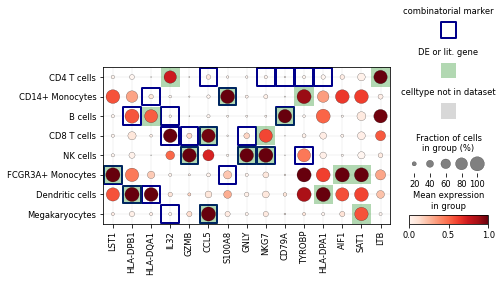

In [10]:
pl.masked_dotplot(adata, selector, n_genes=15)

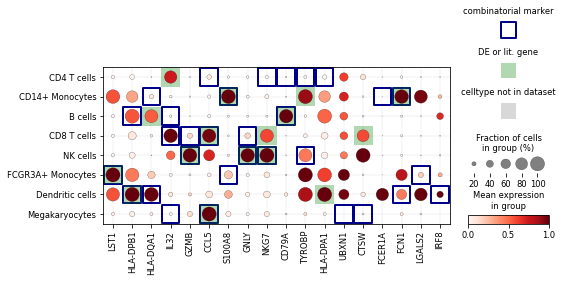

In [11]:
pl.masked_dotplot(adata, selector, comb_markers_only=True)

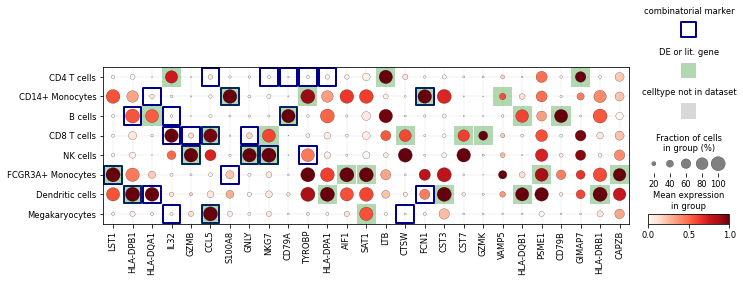

In [12]:
pl.masked_dotplot(adata, selector, markers_only=True)

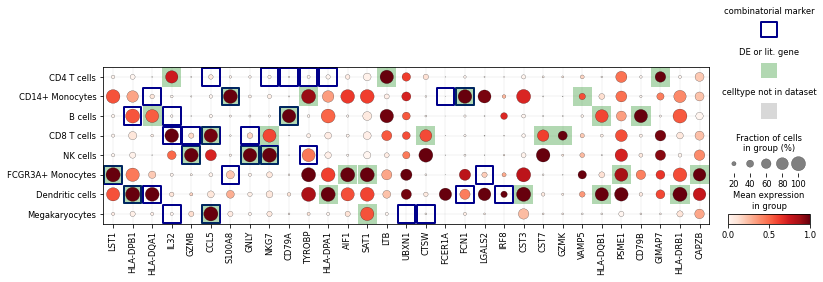

In [13]:
pl.masked_dotplot(adata, selector, comb_markers_only=True, markers_only=True)

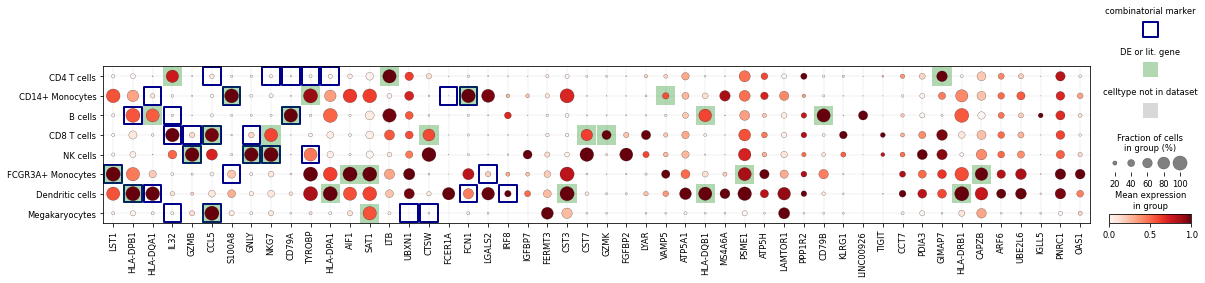

In [14]:
pl.masked_dotplot(adata, selector)

### ii. Select few additional genes

In cases where already some genes of interest are known, one might want to add only a few additional genes to create a probeset. For such a use case, the spapros selection pipeline provides the parameters `preselected_genes` and `prior_genes`. The `preselected_genes` will be the highest ranked genes in the probeset list. The `prior_genes` are prioretized during the selection process but will not be necessarily part of the probeset. 

In [15]:
preselected_genes = selector.probeset[selector.probeset["selection"]].index[:20].to_list()
prior_genes = selector.probeset[selector.probeset["selection"]].index[20:40].to_list()

In [16]:
# create an instance of the ProbesetSelector class
selector = se.ProbesetSelector(adata, 
                            n=50, 
                            celltype_key="celltype", 
                            verbosity=1, 
                            save_dir=None, 
                            preselected_genes=preselected_genes,
                            prior_genes=prior_genes)

The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3


In [17]:
selector.select_probeset()

Output()

In [18]:
# venn diagramm?

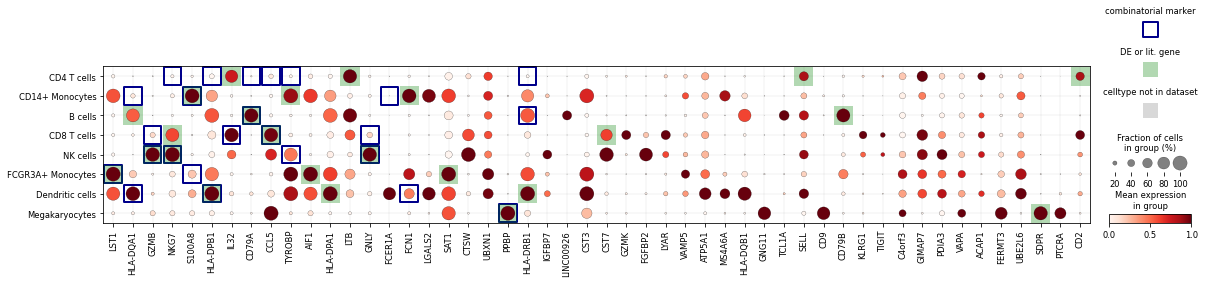

In [19]:
pl.masked_dotplot(adata, selector)

### iii. Cell type classification only

In [20]:
# TODO

In [21]:
selector = se.ProbesetSelector(adata, 
                            n=50, 
                            celltype_key="celltype", 
                            verbosity=1, 
                            save_dir=None, 
#                             DE_selection_hparams={"per_group": True}, 
#                             n_pca_genes=0
                            )

The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3


### iv. Selection with curated marker list

Select genes from a marker list based on correlations with already selected genes. The following list was taken from this [scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

In [22]:
marker_list = {'CD4 T cells': ['IL7R'], 'CD14+ Monocytes': ['CD14', 'LYZ'], 'B cells': ['MS4A1'], 'CD8 T cells': ['CD8A'], 'NK cells': ['GNLY', 'NKG7'], 'FCGR3A+ Monocytes': ['FCGR3A', 'MS4A7'], 'Dendritic cells': ['FCER1A', 'CST3'], 'Megakaryocytes': ['NAPA-AS1', 'PPBP']}
marker_list

{'CD4 T cells': ['IL7R'],
 'CD14+ Monocytes': ['CD14', 'LYZ'],
 'B cells': ['MS4A1'],
 'CD8 T cells': ['CD8A'],
 'NK cells': ['GNLY', 'NKG7'],
 'FCGR3A+ Monocytes': ['FCGR3A', 'MS4A7'],
 'Dendritic cells': ['FCER1A', 'CST3'],
 'Megakaryocytes': ['NAPA-AS1', 'PPBP']}

In [23]:
selector = se.ProbesetSelector(adata, 
                            n=50, 
                            celltype_key="celltype", 
                            verbosity=1, 
                            save_dir=None, 
                            marker_list=marker_list)

The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3
Filter out genes in marker dict that occur multiple times.


In [24]:
selector.select_probeset()

Output()

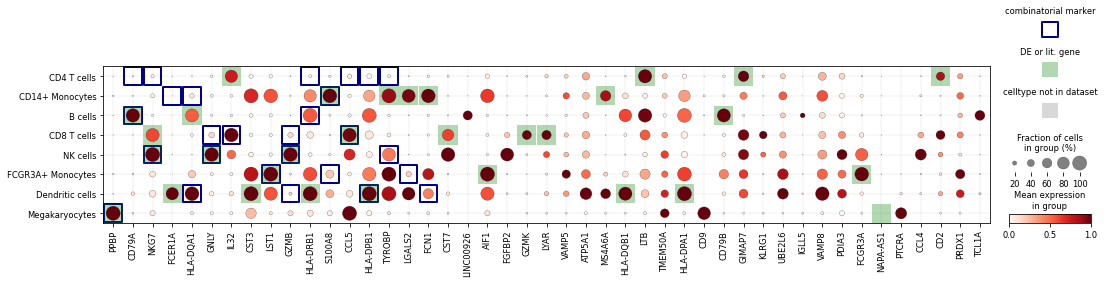

In [25]:
pl.masked_dotplot(adata, selector)

Fields highlighted in green mark markers from the curated list or differentially expressed genes.  

## 4. Reference probeset selection

After selecting probesets, they should be evaluated. As a reference, basic selection methods based on PCA, DE, variability or random can be used. Spapros integrates a quick method for these four attempts:  


With the method `select_reference_probesets` you can easily select reference probesets.
By default, 4 sets are created: 

- `pca_selection`: PCA based selection
- `hvg_selection`: Selection of highly variable genes
- `de_selection`: Differentially expressed genes selection
- `random_selection`: Random gene selection

The selection methods can be altered with the parameter `reference_selections`. 
It takes a dictionary, where the keys are the wanted selection method names and the values are their hyper parameters. 

An easy way to select several random gene sets is provided by the parameter `seeds`, which takes a list of seeds. Each list entry is used as seed for one random gene set selection. 

In [26]:
reference_sets = se.select_reference_probesets(adata, 50, verbosity=2, seeds=[1, 2, 3])

Output()

In [27]:
css = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(css))

In [28]:
display(reference_sets["ref_HVG"].head())  
display(reference_sets["ref_PCA"].head())
display(reference_sets["ref_random (seed=1)"].head())

,selection
index,
CPSF3L,False
ATAD3C,True
RER1,False
TNFRSF25,False
TNFRSF9,False


,selection,selection_score,selection_ranking
index,,,
CPSF3L,False,0.125340,419.0
ATAD3C,False,0.038324,864.0
RER1,False,0.358249,124.0
TNFRSF25,False,0.183054,287.0
TNFRSF9,False,0.042982,840.0


,selection
index,
CPSF3L,False
ATAD3C,False
RER1,False
TNFRSF25,False
TNFRSF9,False


In [29]:
display(reference_sets["ref_DE"].head())  

,selection,CD4 T cells,CD14+ Monocytes,B cells,CD8 T cells,NK cells,FCGR3A+ Monocytes,Dendritic cells,Megakaryocytes
index,,,,,,,,,
CPSF3L,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATAD3C,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RER1,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TNFRSF25,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TNFRSF9,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# the highest ranked genes of each selection: 
merged_df = pd.DataFrame()
for ref_name, ref_df in reference_sets.items(): 
    merged_df[ref_name] = ref_df.index[ref_df.selection]
merged_df.head()

,ref_HVG,ref_PCA,ref_DE,ref_random (seed=1),ref_random (seed=2),ref_random (seed=3)
0,ATAD3C,CAPZB,CAPZB,UBIAD1,RP11-70P17.1,S100A8
1,C1QC,CD2,CD2,PGM1,TAL1,IL24
2,ZNF436,S100A8,S100A8,CHI3L2,HDGF,RP1-28O10.1
3,SPOCD1,CD48,FCER1A,KIAA0040,CD48,VAMP8
4,C2CD4D,SELL,GNLY,RP11-378J18.3,RNF187,TMEM40


## 5. What's next? 



See our [basic evaluation tutorial](https://spapros.readthedocs.io/en/latest/tutorials/spapros_tutorial_basic_evaluation.html) or our [advanced evaluation tutorial](https://spapros.readthedocs.io/en/latest/tutorials/spapros_tutorial_advanced_evaluation.html) for detailed instructions to evaluate the selected probesets.